In [1]:
import tensorflow as tf

In [7]:
print('this is the current version of tensorflow i am using', tf.__version__)

this is the current version of tensorflow i am using 2.4.0


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
import pathlib
dataset_url = "https://newsimland.com/~destinnie-rickard/fish_photojpg.tar.gz"
data_dir = tf.keras.utils.get_file('fish_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [11]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

214


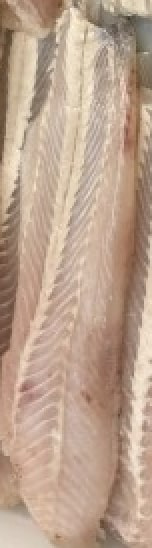

In [12]:
agrade = list(data_dir.glob('agrade/*'))
PIL.Image.open(str(agrade[0]))